In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN


from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:


#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_26=df["Close"].rolling(26).mean()
    MA_52=df["Close"].rolling(52).mean()
    df=df.assign(MA_26=MA_26,MA_52=MA_52).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df
   
    #시간
def get_time(df):
    time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)
    
    return df




def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)


In [3]:
a=fdr.DataReader("KS11","2010-01-01")

In [3]:
KS11 = fdr.DataReader("KS11","2010-01-01","2019-01-01")
KQ11= fdr.DataReader("KQ11","2010-01-01","2019-01-01")
US500 = fdr.DataReader("US500","2010-01-01","2019-01-01")
HSI = fdr.DataReader("HSI","2010-01-01","2019-01-01")
IXIC = fdr.DataReader("IXIC","2010-01-01","2019-01-01")

In [4]:
BATCH=20

df=get_stochastic(df)
df=get_MA(df)
df['Momentum_1D'] = (df['Close']-df['Close'].shift(1))
df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi)
df=df.dropna()

df=df[0:-(len(df)%BATCH)]
df_before=df[0:-1] #값과 값 -> [0:-1] 이평선 -> [25:]  <- [25: 0 XXXX]

NameError: name 'df' is not defined

C:\Program Files\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


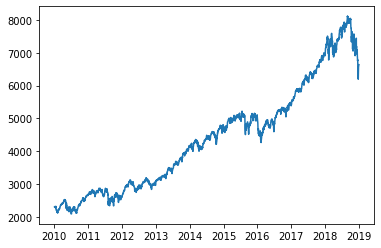

In [5]:
plt.plot(IXIC["Close"])

In [112]:
df

,Close,Open,High,Low,Volume,Change,kdj_k,kdj_d,kdj_j,MA_26,MA_52,RSI_14D
Date,,,,,,,,,,,,
2010-05-06,0.119419,0.111434,0.104431,0.134073,0.370629,0.377224,0.126718,0.340004,0.444884,0.091234,0.012752,0.518702
2010-05-07,0.083549,0.065241,0.074323,0.088305,0.377085,0.356762,0.164254,0.266615,0.354381,0.089259,0.013228,0.451532
2010-05-10,0.112594,0.093695,0.095085,0.115398,0.316845,0.716192,0.392632,0.299201,0.325683,0.087450,0.014367,0.531596
2010-05-11,0.105470,0.123739,0.107592,0.122318,0.377647,0.514235,0.336618,0.300932,0.312214,0.085132,0.015708,0.577717
2010-05-12,0.098519,0.110458,0.095651,0.118489,0.374448,0.515125,0.281968,0.282581,0.296157,0.082434,0.017472,0.551707
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-01,0.446933,0.458149,0.460594,0.465223,0.284039,0.530249,0.195661,0.100794,0.068947,0.601726,0.672501,0.200921
2018-11-02,0.515896,0.469370,0.501971,0.485614,0.307323,0.867438,0.559140,0.248083,0.156998,0.591823,0.668696,0.361265
2018-11-05,0.497503,0.501766,0.486224,0.492942,0.298495,0.472420,0.462199,0.311675,0.233329,0.580405,0.664868,0.374483


In [5]:
import time
start = time.time()
Xtrain_size=0
예측dic={}
수익률dic={}
END=0
초기돈=10000
d=1
dd=20
BATCH = 20
count = 0
pred_dic={}
투자결과=[]

총df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])
세트df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])


  
for 인덱스,인덱스명 in zip([KS11,KQ11,IXIC,HSI,US500],["KS11","KQ11","IXIC","HSI","US500"]):

    df = 인덱스
    df=get_stochastic(df)
    df=get_MA(df)
    df['Momentum_1D'] = (df['Close']-df['Close'].shift(1))
    df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi)
    df=df.dropna()
    df=df[0:-(len(df)%BATCH)]
    df = df.drop(labels = ['Momentum_1D'], axis=1)
    
    MA_26=df["Close"].rolling(21).mean()
    y_before=MA_26.dropna()
    
    dfA=df[20:] #값과 값 -> [:] 이평선 -> [20:]  <- [20: 0 XXXX]
    
    y=np.where(np.array(dfA["Close"].shift(-1).dropna())>np.array(y_before.shift(-1).dropna()),1,0) #값과 이평선 ( 1일 차 )
    #y=np.where(dfA["Change"].shift(-1).dropna()>0,1,0) #값과 값 ( 1일 차 )
    #y=np.where(np.array(dfA["Close"].shift(-20).dropna())>np.array(y_before.shift(-20).dropna()),1,0) #값과 이평선( 20일 차 )
    #y=np.where(dfA["Change"].shift(-20).dropna()>0,1,0) #값과 값 ( 20일 차 )
    
    df = dfA[:-1] # 1일차일시 [:-1] 20일차일시 [:-20]
    
    
    nparr=df
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    df["Close"]=scaler.fit_transform(nparr["Close"].values.reshape(-1,1))
    df["Open"]=scaler.fit_transform(nparr["Open"].values.reshape(-1,1))
    df["High"]=scaler.fit_transform(nparr["High"].values.reshape(-1,1))
    df["Low"]=scaler.fit_transform(nparr["Low"].values.reshape(-1,1))
    df["Volume"]=scaler.fit_transform(nparr["Volume"].values.reshape(-1,1))
    df["Change"]=scaler.fit_transform(nparr["Change"].values.reshape(-1,1))
    df["kdj_k"]=scaler.fit_transform(nparr["kdj_k"].values.reshape(-1,1))
    df["kdj_d"]=scaler.fit_transform(nparr["kdj_d"].values.reshape(-1,1))
    df["kdj_j"]=scaler.fit_transform(nparr["kdj_j"].values.reshape(-1,1))
    df["MA_26"]=scaler.fit_transform(nparr["MA_26"].values.reshape(-1,1))
    df["MA_52"]=scaler.fit_transform(nparr["MA_52"].values.reshape(-1,1))
    df["RSI_14D"]=scaler.fit_transform(nparr["RSI_14D"].values.reshape(-1,1))

    X=df.values

    setlen=int(len(X)/20*0.7)*20

    X_train=X[:setlen]
    X_test=X[setlen:]
    y_train=y[:setlen]
    y_test=y[setlen:]

    X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

    model = Sequential()
    model.add(LSTM(36, input_shape=(1, 12),return_sequences=True))
    model.add(LSTM(36, input_shape=(1, 12)))
    for i in range(2):
        model.add(Dense(18,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model.fit(X_train, y_train, epochs=100, batch_size=16,validation_split=0.1,verbose=0)
    pred=np.where(model.predict(X_test)>0.5,1,0)
    
    print(인덱스명, "정확도 : ", accuracy_score(y_test,np.where(model.predict(X_test)>0.5,1,0)))
    예측dic[인덱스명]=pred
    수익률dic[인덱스명]=dfA["Close"][setlen:]

    #예측머신 끝 --------predict -> 12근방 나옴 ---------------------


        
        
버튼=1
date=0

while 버튼==1:#예측머신돌리기
    day= str(d+(20*date)) +"~" + str(dd+(20*date)) + "일 차"
    date=date+1
    print(day,"---------------------------------")

    세트df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])
       
    
    for x,y in zip(예측dic.keys(),예측dic.values()):
        
           #종료 조건
        if(len(수익률dic[x])==BATCH+20):
            버튼=0
            print("종료, 리밸런싱 수 : " , count)
            print(pred_dic)
            break
            
        
        pred=y[BATCH-20:BATCH]
        pred_sum=sum(pred)
        if count==0:
            pred_dic[x]=0
        pred_dic[x]=pred_dic[x]+pred_sum
        예측 = (pred_sum)/20
        실제수익률 = ((수익률dic[x][BATCH+20])/(수익률dic[x][BATCH]))-1
        턴df=pd.DataFrame(data={"영업일":[day],"인덱스":[x],"상승예측확률":[예측],"실제수익률":[실제수익률] }, columns=["영업일","인덱스","상승예측확률","실제수익률"])
        세트df=pd.concat([세트df,턴df])    

           
    if 버튼==0:
        break
        
        
        
    earn_list=[]             
    for x,y in zip(세트df["상승예측확률"],세트df["실제수익률"]):
        
        if x>=0.6:
            earn_list.append(y)
    
    #하나도 상승 아닐때 규제 줄이기
    if len(earn_list)==0:
        for x,y in zip(세트df["상승예측확률"],세트df["실제수익률"]):
        
            if x>=0.4:
                earn_list.append(y)
        
    earn_list2=[]
    if len(earn_list)!=0:
        초기돈=초기돈/(len(earn_list))
        for y in earn_list:
            earn_list2.append(초기돈+(초기돈*y))
        초기돈=sum(earn_list2)    
    else:
        earn_list2.append(초기돈)
    

    총df=pd.concat([총df,세트df])
    BATCH=BATCH+20

    print("분산 투자 : ",earn_list2)
    print("투자 결과 : ",초기돈)
    count=count+1
    print("\n★")
    print(세트df)
    print("★\n")
    
   
            #MONEY = 투잣돈 * A의 20일후 change + 투잣돈 * B의 20일후 change #"20일차MONEY"출력


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

KS11 정확도 :  0.8575899843505478
KQ11 정확도 :  0.6275430359937402
IXIC 정확도 :  0.8179059180576631
HSI 정확도 :  0.8012519561815337
US500 정확도 :  0.7481031866464339
1~20일 차 ---------------------------------
분산 투자 :  [8535.14853263407]
투자 결과 :  8535.14853263407

★
       영업일    인덱스  상승예측확률     실제수익률
0  1~20일 차   KS11  [0.15] -0.103639
0  1~20일 차   KQ11   [0.5] -0.146485
0  1~20일 차   IXIC  [0.15]  0.033506
0  1~20일 차    HSI  [0.35] -0.041840
0  1~20일 차  US500   [0.3]  0.030645
★

21~40일 차 ---------------------------------
분산 투자 :  [4670.043916346764, 4656.915536970977]
투자 결과 :  9326.95945331774

★
        영업일    인덱스  상승예측확률     실제수익률
0  21~40일 차   KS11   [0.5]  0.233512
0  21~40일 차   KQ11   [0.4]  0.254114
0  21~40일 차   IXIC   [0.7]  0.094309
0  21~40일 차    HSI  [0.45]  0.219622
0  21~40일 차  US500  [0.65]  0.091232
★

41~60일

0  441~460일 차  US500   [0.3] -0.011289
★

461~480일 차 ---------------------------------
분산 투자 :  [15292.482994670492]
투자 결과 :  15292.482994670492

★
          영업일    인덱스  상승예측확률     실제수익률
0  461~480일 차   KS11  [0.35]  0.037911
0  461~480일 차   KQ11   [0.0] -0.047825
0  461~480일 차   IXIC  [0.65] -0.012021
0  461~480일 차    HSI  [0.05]  0.046879
0  461~480일 차  US500  [0.15] -0.003863
★

481~500일 차 ---------------------------------
분산 투자 :  [15144.375009991278]
투자 결과 :  15144.375009991278

★
          영업일    인덱스  상승예측확률     실제수익률
0  481~500일 차   KS11  [0.65] -0.009685
0  481~500일 차   KQ11   [0.0]  0.048543
0  481~500일 차   IXIC   [0.0]  0.013591
0  481~500일 차    HSI  [0.15] -0.043062
0  481~500일 차  US500  [0.05]  0.003005
★

501~520일 차 ---------------------------------
분산 투자 :  [16135.037294335993]
투자 결과 :  16135.037294335993

★
          영업일    인덱스  상승예측확률     실제수익률
0  501~520일 차   KS11  [0.15] -0.207280
0  501~520일 차   KQ11   [0.0] -0.135675
0  501~520일 차   IXIC  [0.45]  0.065415
0  501~520

In [57]:

dfA["Close"]

Date
2010-05-06       0.055325
2010-05-07       0.046275
2010-05-10       0.071875
2010-05-11       0.069810
2010-05-12       0.078132
                 ...     
2018-11-26    2673.450000
2018-11-27    2682.170000
2018-11-28    2743.790000
2018-11-29    2737.760000
2018-11-30    2760.170000
Name: Close, Length: 2160, dtype: float64

In [6]:
y=np.where(np.array(dfA["Close"][20:])>np.array(y_before[20:]),1,0)
y

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
y=np.where(np.array(dfA["Close"].shift(-20).dropna())>np.array(y_before.shift(-20).dropna()),1,0)
y

array([0, 0, 0, ..., 0, 0, 0])

(2120,)

In [36]:
model.predict(X_test)


array([[0.64919096],
       [0.6283208 ],
       [0.62869966],
       [0.5587075 ],
       [0.52913904],
       [0.46719518],
       [0.57031137],
       [0.55520236],
       [0.565216  ],
       [0.6474572 ],
       [0.5013679 ],
       [0.5691583 ],
       [0.47936416],
       [0.611876  ],
       [0.646947  ],
       [0.65888613],
       [0.6231308 ],
       [0.6622871 ],
       [0.65494335],
       [0.66708934],
       [0.6362884 ],
       [0.663793  ],
       [0.60741615],
       [0.64821434],
       [0.58505416],
       [0.5229235 ],
       [0.4897407 ],
       [0.5913419 ],
       [0.56106794],
       [0.8062049 ],
       [0.8750479 ],
       [0.8731902 ],
       [0.8739071 ],
       [0.67576975],
       [0.6505736 ],
       [0.6362762 ],
       [0.8395217 ],
       [0.7195856 ],
       [0.8377894 ],
       [0.8621841 ],
       [0.8586443 ],
       [0.7878351 ],
       [0.73842335],
       [0.57372946],
       [0.6032931 ],
       [0.56565225],
       [0.59905505],
       [0.574